In [1]:
import sys
# import comet_ml
import torch

import numpy as np

from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, accuracy_score,
)
# from transformers.integrations import CometCallback

sys.path.append('..')
from lib.utils import set_seed, get_device
from lib.utils.constants import RANDOM_SEED
from lib.data.loading import pd_read_jsonl_file

In [2]:
# import os
# from dotenv import load_dotenv

# load_dotenv()

# comet_api_key = os.getenv("COMET_API_KEY")
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import torch

torch.cuda.empty_cache()

In [3]:
set_seed(RANDOM_SEED)

DEVICE = get_device()
print(f'Using device: {DEVICE}')

Using device: mps


In [4]:
df_en_train = pd_read_jsonl_file('../data/en_train.jsonl')
df_en_dev = pd_read_jsonl_file('../data/en_dev.jsonl')
df_en_test = pd_read_jsonl_file('../data/en_devtest_text_id_only.jsonl')

In [5]:
df_en_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610767 entries, 0 to 610766
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          610767 non-null  object
 1   source      610767 non-null  object
 2   sub_source  610767 non-null  object
 3   lang        610767 non-null  object
 4   model       610767 non-null  object
 5   label       610767 non-null  int64 
 6   text        610767 non-null  object
dtypes: int64(1), object(6)
memory usage: 32.6+ MB


In [6]:
df_en_train.head()

,id,source,sub_source,lang,model,label,text
0,f05034ca-d1da-445d-a6a2-5869ade0dfc3,m4gt,reddit,en,llama3-8b,1,Hitler's plans for the succession and power st...
1,e7d7fe23-3709-4e14-aa2d-d76821dcbdf6,mage,squad,en,human,0,The Bush administration then turned its attent...
2,1a68d42e-4202-4e36-bceb-02d693440a14,mage,yelp,en,human,0,Really really the best pedi ever! Pho was so a...
3,5de844ab-c197-4378-b144-c3a46e3f5b67,mage,xsum,en,human,0,The PS42m MV Loch Seaforth made its first pass...
4,cdf050ad-7d90-4235-b7c6-46ca6cfc4382,m4gt,wikipedia,en,human,0,Malta participated in the Eurovision Song Cont...


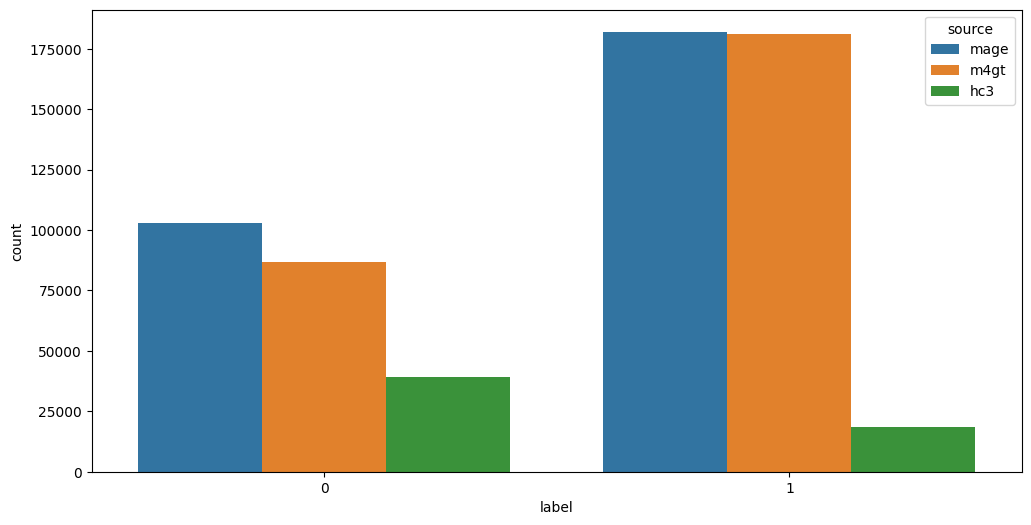

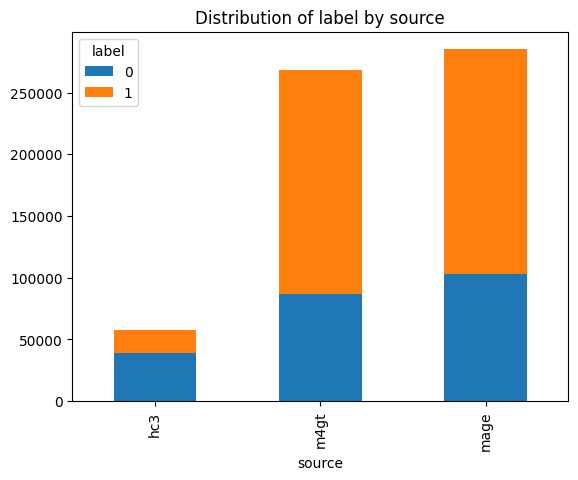

In [12]:
# Plot distribution of the lable column by the source column and plot count of each label by source
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df_en_train, x='label', hue='source')
# count each label by source
df_en_train.groupby(['source', 'label']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of label by source')
plt.show()

# Split the datasets by the source

In [24]:
ood_datasets = {}

train_sources = df_en_train['source'].unique().tolist()
for source in train_sources:
    # Get samples with the same source
    ood_train = df_en_train[df_en_train['source'] == source]
    # Randomly keep same number of samples by label
    ood_train = ood_train.groupby('label').apply(lambda x: x.sample(ood_train['label'].value_counts().min(), random_state=RANDOM_SEED))
    # Shuffle samples
    ood_train = ood_train.sample(frac=1, random_state=RANDOM_SEED)

    # For validation keep all samples with different source
    ood_dev = df_en_train[df_en_train['source'] != source]
    # Randomly keep same number of samples by label
    ood_dev = ood_dev.groupby('label').apply(lambda x: x.sample(ood_dev['label'].value_counts().min(), random_state=RANDOM_SEED))
    ood_dev = ood_dev.sample(frac=1, random_state=RANDOM_SEED)

    ood_datasets[source] = {
        'train': ood_train,
        'dev': ood_dev,
    }

# Fine-tune models

In [33]:
MODEL_NAME = "distilbert/distilbert-base-cased"

MAX_LEN = 512

TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 16
LEARNING_RATE = 2e-4
NUM_EPOCHS = 1
WEIGHT_DECAY = 1e-2

training_params = {
    "model_name": MODEL_NAME,
    "max_len": MAX_LEN,
    "train_batch_size": TRAIN_BATCH_SIZE,
    "eval_batch_size": EVAL_BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "num_epochs": NUM_EPOCHS,
    "weight_decay": WEIGHT_DECAY,
    "seed": RANDOM_SEED,
}

In [34]:
import torch
import torch.nn.functional as F

from transformers import Trainer


class WeightedCrossEntropyTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(
                class_weights, dtype=torch.float32
        ).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
from datasets import Dataset, DatasetDict
from transformers import DataCollatorWithPadding, TrainingArguments


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'macro_f1': f1_score(predictions, labels, average='macro'),
        'accuracy': accuracy_score(predictions,labels),
        'balanced_accuracy': balanced_accuracy_score(predictions, labels),
    }


def preprocess_dataset(tokenizer, ds, max_len=MAX_LEN):
    return tokenizer(ds['text'], truncation=True, max_length=max_len)


def set_model_parameters(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.distilbert.transformer.layer[-1].parameters():
        param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True

    return model


def fine_tune_models(datasets, MODEL_NAME, training_params, device=DEVICE):
    fine_tuned_models = {}

    for source, ds in datasets.items():
        print(f'Fine-tuning model for source: {source}')

        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        model = set_model_parameters(model)
        model.to(device)

        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        # class_weights = (
        #     1 / ds['train'].label.value_counts(normalize=True).sort_index()
        # ).tolist()
        # class_weights = torch.tensor(class_weights)
        # class_weights = class_weights / class_weights.sum()

        ds_train = Dataset.from_pandas(ds['train']).shuffle(
            seed=training_params['seed'],
        )
        ds_dev = Dataset.from_pandas(ds['dev'])

        dataset = DatasetDict({
            'train': preprocess_dataset(tokenizer, ds_train, training_params['max_len']),
            'validation': preprocess_dataset(tokenizer, ds_dev, training_params['max_len']),
        })
        dataset.set_format("torch")

        collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

        training_args = TrainingArguments(
            output_dir=f'../results/{MODEL_NAME}/{source}',
            learning_rate=training_params["learning_rate"],
            per_device_train_batch_size=training_params["train_batch_size"],
            per_device_eval_batch_size=training_params["eval_batch_size"],
            num_train_epochs=training_params["num_train_epochs"],
            weight_decay=training_params["weight_decay"],
            evaluation_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            seed=training_params["seed"],
        )

        trainer = WeightedCrossEntropyTrainer(
            model=model,
            args=training_args,
            train_dataset=dataset['train'],
            eval_dataset=dataset['dev'],
            tokenizer=tokenizer,
            data_collator=collate_fn,
            compute_metrics=compute_metrics,
            # class_weights=class_weights,
            # callbacks=[CometCallback()],
        )

        train_result = trainer.train()

        metrics = train_result.metrics
        max_train_samples = len(ds_train)
        metrics["train_samples"] = min(max_train_samples, len(ds_train))
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

        trainer.save_model(f"../results/{MODEL_NAME}/{source}/fine-tuned-model")

        fine_tuned_models[source] = f"../results/{MODEL_NAME}/{source}/fine-tuned-model"

    return fine_tuned_models

In [70]:
import pandas as pd
from tqdm import tqdm


def make_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=16):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")

            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions,
    })

    df_predictions.to_json(
        file_path,
        orient="records",
        lines=True,
    )

    return df_predictions


In [71]:
df_test_predictions = make_predictions(
    trainer.model,
    tokenizer,
    df_en_test,
    DEVICE,
    "./subtask_a.jsonl",
)

100%|██████████| 2035/2035 [01:46<00:00, 19.14it/s]


In [77]:
df_en_train.label.value_counts(normalize=True)

label
1    0.625189
0    0.374811
Name: proportion, dtype: float64

In [79]:
df_en_dev.label.value_counts(normalize=True)

label
1    0.624355
0    0.375645
Name: proportion, dtype: float64

In [76]:
df_test_predictions.label.value_counts(normalize=True)

label
1    0.720859
0    0.279141
Name: proportion, dtype: float64

In [48]:
# experiment.end()